## 1.  Importing Required Libraries

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import numpy as np
import warnings
warnings.filterwarnings('ignore')


## 2.Data Exploration and Loading

In [2]:
df = pd.read_csv('movie_review.csv')
df.head()


,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


In [3]:
df.shape

(64720, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64720 entries, 0 to 64719
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   fold_id  64720 non-null  int64 
 1   cv_tag   64720 non-null  object
 2   html_id  64720 non-null  int64 
 3   sent_id  64720 non-null  int64 
 4   text     64720 non-null  object
 5   tag      64720 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.0+ MB


In [5]:
df.describe()

,fold_id,html_id,sent_id
count,64720.000000,64720.000000,64720.00000
mean,4.549382,16074.097373,18.98118
std,2.853176,7175.282521,15.08369
min,0.000000,42.000000,0.00000
25%,2.000000,10613.000000,8.00000
50%,5.000000,15091.000000,16.00000
75%,7.000000,21865.000000,27.00000
max,9.000000,29867.000000,111.00000


### Count and Visualize Sentiments

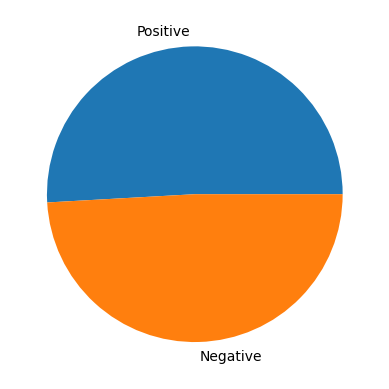

In [6]:
df['tag'].value_counts().reset_index()
data_dist = [len(df[df['tag']=='pos']), len(df[df['tag']=='neg'])]
labels = ['Positive','Negative']
plt.pie(data_dist, labels = labels)
plt.show()


> Observation - Occurance of `positive` is slightly more than that of `negative`

## 3. Data Cleaning

### Checking for Duplicates

In [7]:
df.duplicated().sum()

0

> No Duplicates present

### Dropping Unnecessary Columns

In [8]:
df = df.drop(columns=['fold_id', 'cv_tag', 'html_id', 'sent_id'])


In [9]:
df.head()

,text,tag
0,films adapted from comic books have had plenty...,pos
1,"for starters , it was created by alan moore ( ...",pos
2,to say moore and campbell thoroughly researche...,pos
3,"the book ( or "" graphic novel , "" if you will ...",pos
4,"in other words , don't dismiss this film becau...",pos


## 4. Text Preprocessing

### Tokenization
Spliting the review text into individual words (tokens).

In [10]:
#import nltk
#nltk.download('punkt')


In [11]:
from nltk.tokenize import word_tokenize
df['tokens'] = df['text'].apply(word_tokenize)
df['tokens']

0        [films, adapted, from, comic, books, have, had...
1        [for, starters, ,, it, was, created, by, alan,...
2        [to, say, moore, and, campbell, thoroughly, re...
3        [the, book, (, or, ``, graphic, novel, ,, ``, ...
4        [in, other, words, ,, do, n't, dismiss, this, ...
                               ...                        
64715    [that, lack, of, inspiration, can, be, traced,...
64716    [like, too, many, of, the, skits, on, the, cur...
64717    [after, watching, one, of, the, ``, roxbury, `...
64718    [bump, unsuspecting, women, ,, and, ., ., ., t...
64719    [after, watching, _a_night_at_the_roxbury_, ,,...
Name: tokens, Length: 64720, dtype: object

### Removing StopWords
Filtering out common words (like 'the', 'is') that are not informative for sentiment analysis.

In [12]:
#import nltk
#nltk.download('all')

In [13]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])


In [14]:
df['tokens']

0        [films, adapted, comic, books, plenty, success...
1        [starters, ,, created, alan, moore, (, eddie, ...
2        [say, moore, campbell, thoroughly, researched,...
3        [book, (, ``, graphic, novel, ,, ``, ), 500, p...
4                [words, ,, n't, dismiss, film, source, .]
                               ...                        
64715    [lack, inspiration, traced, back, insipid, cha...
64716    [like, many, skits, current, incarnation, _sat...
64717    [watching, one, ``, roxbury, ``, skits, snl, ,...
64718       [bump, unsuspecting, women, ,, ., ., ., 's, .]
64719    [watching, _a_night_at_the_roxbury_, ,, 'll, l...
Name: tokens, Length: 64720, dtype: object

### Stemming
Reduces words to their root form (e.g., 'running' to 'run') to unify different forms of a word.

In [15]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
df['tokens'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])


In [16]:
df['tokens']

0        [film, adapt, comic, book, plenti, success, ,,...
1        [starter, ,, creat, alan, moor, (, eddi, campb...
2        [say, moor, campbel, thoroughli, research, sub...
3        [book, (, ``, graphic, novel, ,, ``, ), 500, p...
4                  [word, ,, n't, dismiss, film, sourc, .]
                               ...                        
64715     [lack, inspir, trace, back, insipid, charact, .]
64716    [like, mani, skit, current, incarn, _saturday_...
64717    [watch, one, ``, roxburi, ``, skit, snl, ,, co...
64718          [bump, unsuspect, women, ,, ., ., ., 's, .]
64719    [watch, _a_night_at_the_roxbury_, ,, 'll, left...
Name: tokens, Length: 64720, dtype: object

### Vectorization (TF-IDF)
Converts the textual data into numerical format using TF-IDF (Term Frequency-Inverse Document Frequency), capturing the importance of words in the reviews.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])
y = df['tag']


In [18]:
X

<64720x39659 sparse matrix of type '<class 'numpy.float64'>'
	with 1148672 stored elements in Compressed Sparse Row format>

In [19]:
y

0        pos
1        pos
2        pos
3        pos
4        pos
        ... 
64715    neg
64716    neg
64717    neg
64718    neg
64719    neg
Name: tag, Length: 64720, dtype: object

## 5. Sentiment Analysis Model

### Train-Test Split
Splitting the data into training and testing sets to evaluate the model's performance.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Model Training (Logistic Regression)
Training a Logistic Regression model on the training data to classify reviews as positive or negative

In [21]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

### Model Evaluation
Predicting the sentiment of the test data and printing a report showing the model's accuracy, precision, recall, and F1-score.

In [22]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         neg       0.69      0.68      0.68      6371
         pos       0.69      0.71      0.70      6573

    accuracy                           0.69     12944
   macro avg       0.69      0.69      0.69     12944
weighted avg       0.69      0.69      0.69     12944



> Test set Accuracy is 69%

## Multinomial Naive Bayes
Train and evaluate the Multinomial Naive Bayes model

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Initialize and train the Multinomial Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_nb = nb_model.predict(X_test)

# Print accuracy and F1 score
print("Multinomial Naive Bayes:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")
print(classification_report(y_test, y_pred_nb))


Multinomial Naive Bayes:
Accuracy: 0.7106
F1 Score: 0.7102
              precision    recall  f1-score   support

         neg       0.72      0.67      0.70      6371
         pos       0.70      0.75      0.72      6573

    accuracy                           0.71     12944
   macro avg       0.71      0.71      0.71     12944
weighted avg       0.71      0.71      0.71     12944



## 6. Customer Segmentation with K-Means Clustering

### Simulate Customer Data
Generating a synthetic dataset for 100 customers, including the number of purchases, average purchase value, and recency (days since last purchase).

In [24]:
np.random.seed(42)
customer_data = {
    'customer_id': range(1, 101),
    'num_purchases': np.random.randint(1, 20, 100),
    'avg_purchase_value': np.random.uniform(10, 500, 100),
    'recency': np.random.randint(1, 365, 100),
}
df_customers = pd.DataFrame(customer_data)


In [25]:
df_customers

,customer_id,num_purchases,avg_purchase_value,recency
0,1,7,144.613679,60
1,2,15,285.009279,2
2,3,11,197.634169,304
3,4,8,486.138927,254
4,5,7,425.967774,140
...,...,...,...,...
95,96,16,275.309507,360
96,97,5,350.934356,174
97,98,3,121.989511,280
98,99,12,95.727914,114


### Feature Scaling
Scaling the customer features to ensure they are on a similar scale, which is crucial for K-Means clustering.

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = ['num_purchases', 'avg_purchase_value', 'recency']
df_customers_scaled = scaler.fit_transform(df_customers[features])


In [27]:
df_customers_scaled

array([[-0.50097131, -0.76539054, -1.12959609],
       [ 1.01712358,  0.2909666 , -1.71057129],
       [ 0.25807613, -0.36645658,  1.31450647],
       [-0.31120945,  1.80429565,  0.81366578],
       [-0.50097131,  1.35155905, -0.32825099],
       [ 1.77617103,  0.88265188, -1.3599828 ],
       [ 0.25807613, -0.90820689, -0.12791471],
       [ 0.25807613, -0.83416276, -1.64045359],
       [-1.0702569 , -1.6291718 ,  0.60331269],
       [-0.31120945,  0.84185107, -0.73894035],
       [-1.26001876, -1.36940782, -0.25813329],
       [-1.44978062, -0.15848376,  1.31450647],
       [ 0.44783799, -1.03453884,  0.35289235],
       [-0.69073318,  1.52428629, -0.41840231],
       [-1.44978062, -0.02563348, -0.20804922],
       [-1.63954248,  0.29845878, -1.18969697],
       [ 0.44783799,  0.78600735, -0.52858726],
       [ 0.44783799, -1.26455199, -0.1178979 ],
       [ 1.3966473 ,  0.45014172, -0.56865452],
       [ 0.06831427,  0.21205979, -0.97934388],
       [ 1.20688544, -1.02959102, -0.598

### Elbow Method for Optimal Clusters
Ploting the inertia (sum of squared distances) for different numbers of clusters to determine the optimal number using the Elbow Method.

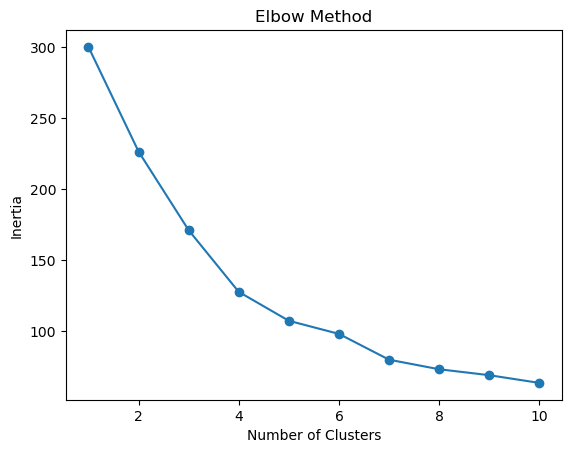

In [28]:
from sklearn.cluster import KMeans
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_customers_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


### K-Means Clustering
Applying K-Means clustering to segment customers into three groups based on their purchasing behavior

In [29]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_customers['cluster'] = kmeans.fit_predict(df_customers_scaled)


In [30]:
df_customers['cluster']

0     1
1     0
2     2
3     1
4     1
     ..
95    0
96    1
97    2
98    2
99    1
Name: cluster, Length: 100, dtype: int32

### PCA for Visualization
Reducing the dimensionality of the customer data using PCA and visualizes the clusters in a 2D space.

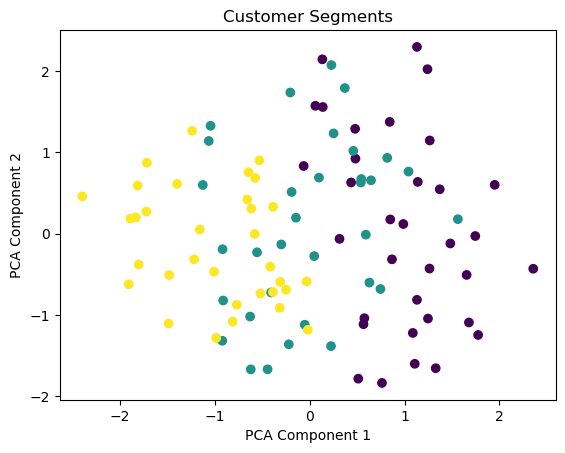

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(df_customers_scaled)
plt.scatter(components[:, 0], components[:, 1], c=df_customers['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments')
plt.show()


## 7. Sentiment Analysis on Customer Segments

### Add Sentiment Data to Customer Segments
Assigning sentiment tags to customer segments and examines if certain clusters have predominant sentiments.

In [32]:
df_customers['tag'] = df['tag']
sentiment_by_cluster = df_customers.groupby('cluster')['tag'].value_counts(normalize=True)
print(sentiment_by_cluster)


cluster  tag
0        pos    1.0
1        pos    1.0
2        pos    1.0
Name: tag, dtype: float64


### Visualize Sentiment Distribution
Displaying the distribution of sentiments across the entire dataset.

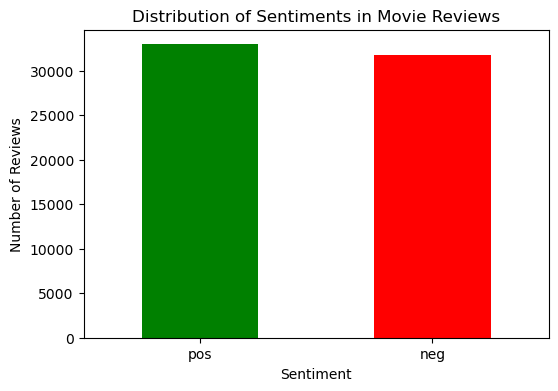

In [33]:
sentiment_counts = df['tag'].value_counts()
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiments in Movie Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()


### Generating Word Clouds
Creating word clouds to visualize the most frequent words in positive and negative reviews.

In [34]:
# pip install wordcloud

In [35]:
from wordcloud import WordCloud
positive_text = " ".join(df[df['tag'] == 'pos']['text'])
negative_text = " ".join(df[df['tag'] == 'neg']['text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)


### Confusion Matrix
Displaying a confusion matrix to analyze the model's performance in classifying sentiments.

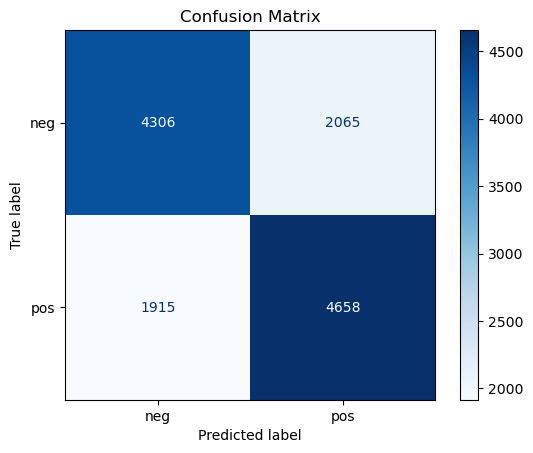

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [37]:
## Getting the Top 5 Suggestions

# For Multinomial Naive Bayes
nb_probabilities = nb_model.predict_proba(X_test)
top_5_nb_indices = np.argsort(nb_probabilities.max(axis=1))[-5:]

print("Top 5 suggestions (Multinomial Naive Bayes):")
for idx in top_5_nb_indices:
    print(f"Review: {X_test[idx]}")
    print(f"Predicted Sentiment: {y_pred_nb[idx]}")
    print()




Top 5 suggestions (Multinomial Naive Bayes):
Review:   (0, 14073)	0.07601671713638251
  (0, 24386)	0.040769344338533825
  (0, 35280)	0.15233549644648062
  (0, 5187)	0.0636995896521327
  (0, 13695)	0.06221327211921662
  (0, 1810)	0.07839233748224692
  (0, 18583)	0.04428659745240455
  (0, 35277)	0.05346085713407872
  (0, 13176)	0.06272396189968478
  (0, 2396)	0.06236890803031774
  (0, 35266)	0.18007220245924557
  (0, 24501)	0.06822332725901911
  (0, 18386)	0.08892396701054711
  (0, 18280)	0.11811212624866399
  (0, 10316)	0.09571923269529242
  (0, 38475)	0.09803763187923446
  (0, 25903)	0.14340121782650536
  (0, 16534)	0.13115458826850152
  (0, 20444)	0.09949128487262227
  (0, 31293)	0.12700343057431404
  (0, 21500)	0.10423041899832172
  (0, 39428)	0.1190642474402299
  (0, 27253)	0.12157416322694711
  (0, 24521)	0.08965594624067619
  (0, 7014)	0.11396317433876305
  (0, 31205)	0.1342760502731479
  (0, 26594)	0.2967791595974736
  (0, 16076)	0.12930974580985943
  (0, 20116)	0.192726179719903

## Testing the model

In [38]:
# Example of testing the models on a new sample
sample_review = ["The movie was fantastic with great acting!"]

# Preprocess the sample
sample_vector = vectorizer.transform(sample_review)

# Predict with Naive Bayes
sample_prediction_nb = nb_model.predict(sample_vector)
print(f"Sentiment Prediction: {sample_prediction_nb[0]}")



Sentiment Prediction: pos


In [39]:
input_text = ['''A disjointed mess with flashes of potential. "Suicide Squad" suffers from an uneven plot, 
                underdeveloped characters, and tonal inconsistencies that undermine its promising premise.''']

# Preprocess the sample
sample_vector = vectorizer.transform(input_text)

# Predict with Naive Bayes
sample_prediction_nb = nb_model.predict(sample_vector)
print(f"Sentiment Prediction: {sample_prediction_nb[0]}")

Sentiment Prediction: neg


In [40]:
input_text = ['''"Whiplash" is a tour de force that resonates deeply. Its intense narrative, fueled by stellar performances and
                an electrifying soundtrack, makes it an unforgettable cinematic experience.''']

# Preprocess the sample
sample_vector = vectorizer.transform(input_text)

# Predict with Naive Bayes
sample_prediction_nb = nb_model.predict(sample_vector)
print(f"Sentiment Prediction: {sample_prediction_nb[0]}")

Sentiment Prediction: pos


In [41]:
input_text = ['''"M. Night Shyamalan's "The Happening" is a misfire, featuring a disjointed plot 
                and cringe-inducing dialogue. Despite a promising premise, it falls flat, lacking both suspense and coherence.''']

# Preprocess the sample
sample_vector = vectorizer.transform(input_text)

# Predict with Naive Bayes
sample_prediction_nb = nb_model.predict(sample_vector)
print(f"Sentiment Prediction: {sample_prediction_nb[0]}")

Sentiment Prediction: neg
